# Test Unfold 1
 Test program for the classes TUnfold and related.

 1. Generate Monte Carlo and Data events
     The events consist of
       signal
       background

     The signal is a resonance. It is generated with a Breit-Wigner,
     smeared by a Gaussian

 2. Unfold the data. The result is:
     The background level
     The shape of the resonance, corrected for detector effects

     Systematic errors from the MC shape variation are included
     and propagated to the result

 3. fit the unfolded distribution, including the correlation matrix

 4. save six plots to a file `testUnfold1.ps`
```
       1  2  3
       4  5  6
```
     1. 2d-plot of the matrix describing the migrations
     2. generator-level distributions
           - blue: unfolded data, total errors
           - green: unfolded data, statistical errors
           - red: generated data
           - black: fit to green data points
     3. detector level distributions
           - blue: unfolded data, folded back through the matrix
           - black: Monte Carlo (with wrong peal position)
           - blue: data
     4. global correlation coefficients
     5. $ \chi^2 $ as a function of $ log(\tau) $
          the star indicates the final choice of $ \tau $
     6. the L curve


 **Version 17.6, in parallel to changes in TUnfold**

#### History:
 - Version 17.5, in parallel to changes in TUnfold
 - Version 17.4, in parallel to changes in TUnfold
 - Version 17.3, in parallel to changes in TUnfold
 - Version 17.2, in parallel to changes in TUnfold
 - Version 17.1, in parallel to changes in TUnfold
 - Version 17.0, updated for using the classes TUnfoldDensity, TUnfoldBinning
 - Version 16.1, parallel to changes in TUnfold
 - Version 16.0, parallel to changes in TUnfold
 - Version 15, with automated L-curve scan
 - Version 14, with changes in TUnfoldSys.cxx
 - Version 13, include test of systematic errors
 - Version 12, catch error when defining the input
 - Version 11,  print chi**2 and number of degrees of freedom
 - Version 10,  with bug-fix in TUnfold.cxx
 - Version 9,  with bug-fix in TUnfold.cxx and TUnfold.h
 - Version 8,  with bug-fix in TUnfold.cxx and TUnfold.h
 - Version 7,  with bug-fix in TUnfold.cxx and TUnfold.h
 - Version 6a, fix problem with dynamic array allocation under windows
 - Version 6, bug-fixes in TUnfold.C
 - Version 5, replace main() by testUnfold1()
 - Version 4, with bug-fix in TUnfold.C
 - Version 3, with bug-fix in TUnfold.C
 - Version 2, with changed ScanLcurve() arguments
 - Version 1, remove L curve analysis, use ScanLcurve() method instead
 - Version 0, L curve analysis included here

 This file is part of TUnfold.

 TUnfold is free software: you can redistribute it and/or modify
 it under the terms of the GNU General Public License as published by
 the Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 TUnfold is distributed in the hope that it will be useful,
 but WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
 GNU General Public License for more details.

 You should have received a copy of the GNU General Public License
 along with TUnfold.  If not, see <http://www.gnu.org/licenses/>.



**Author:** Stefan Schmitt DESY, 14.10.2008  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Thursday, August 29, 2019 at 03:58 AM.</small></i>

In [1]:
%%cpp -d
#include <TError.h>
#include <TMath.h>
#include <TCanvas.h>
#include <TRandom3.h>
#include <TFitter.h>
#include <TF1.h>
#include <TStyle.h>
#include <TVector.h>
#include <TGraph.h>

#include "TUnfoldDensity.h"

 #define VERBOSE_LCURVE_SCAN

In [2]:
using namespace std;

TRandom *rnd=0;

TH2 *gHistInvEMatrix;

TVirtualFitter *gFitter=0;

Generate an event

Negative mass: background event
  positive mass: signal event

In [3]:
Double_t GenerateEvent(Double_t bgr, // relative fraction of background
                       Double_t mass, // peak position
                       Double_t gamma) // peak width
{
  Double_t t;
  if(rnd->Rndm()>bgr) {
    // generate signal event
    // with positive mass
    do {
      do {
        t=rnd->Rndm();
      } while(t>=1.0);
      t=TMath::Tan((t-0.5)*TMath::Pi())*gamma+mass;
    } while(t<=0.0);
    return t;
  } else {
    // generate background event
    // generate events following a power-law distribution
    //   f(E) = K * TMath::power((E0+E),N0)
    static Double_t const E0=2.4;
    static Double_t const N0=2.9;
    do {
      do {
        t=rnd->Rndm();
      } while(t>=1.0);
      // the mass is returned negative
      // In our example a convenient way to indicate it is a background event.
      t= -(TMath::Power(1.-t,1./(1.-N0))-1.0)*E0;
    } while(t>=0.0);
    return t;
  }
}

 A helper function is created: 

In [4]:
%%cpp -d
void chisquare_corr(Int_t &npar, Double_t * /*gin */, Double_t &f, Double_t *u, Int_t /*flag */) {
  //  Minimization function for H1s using a Chisquare method
  //  only one-dimensional histograms are supported
  //  Correlated errors are taken from an external inverse covariance matrix
  //  stored in a 2-dimensional histogram
  Double_t x;
  TH1 *hfit = (TH1*)gFitter->GetObjectFit();
  TF1 *f1   = (TF1*)gFitter->GetUserFunc();

  f1->InitArgs(&x,u);
  npar = f1->GetNpar();
  f = 0;

  Int_t npfit = 0;
  Int_t nPoints=hfit->GetNbinsX();
  Double_t *df=new Double_t[nPoints];
  for (Int_t i=0;i<nPoints;i++) {
    x     = hfit->GetBinCenter(i+1);
    TF1::RejectPoint(kFALSE);
    df[i] = f1->EvalPar(&x,u)-hfit->GetBinContent(i+1);
    if (TF1::RejectedPoint()) df[i]=0.0;
    else npfit++;
  }
  for (Int_t i=0;i<nPoints;i++) {
    for (Int_t j=0;j<nPoints;j++) {
      f += df[i]*df[j]*gHistInvEMatrix->GetBinContent(i+1,j+1);
    }
  }
  delete[] df;
  f1->SetNumberFitPoints(npfit);
}

 A helper function is created: 

In [5]:
%%cpp -d
Double_t bw_func(Double_t *x,Double_t *par) {
  Double_t dm=x[0]-par[1];
  return par[0]/(dm*dm+par[2]*par[2]);
}

  smear the event to detector level
 input:
   mass on generator level (mTrue>0 !)
 output:
   mass on detector level
 

In [6]:
%%cpp -d
Double_t DetectorEvent(Double_t mTrue) {
  // smear by double-gaussian
  static Double_t frac=0.1;
  static Double_t wideBias=0.03;
  static Double_t wideSigma=0.5;
  static Double_t smallBias=0.0;
  static Double_t smallSigma=0.1;
  if(rnd->Rndm()>frac) {
    return rnd->Gaus(mTrue+smallBias,smallSigma);
  } else {
    return rnd->Gaus(mTrue+wideBias,wideSigma);
  }
}

In [7]:
  // switch on histogram errors
  TH1::SetDefaultSumw2();

  // show fit result
  gStyle->SetOptFit(1111);

  // random generator
  rnd=new TRandom3();

  // data and MC luminosity, cross-section
  Double_t const luminosityData=100000;
  Double_t const luminosityMC=1000000;
  Double_t const crossSection=1.0;

  Int_t const nDet=250;
  Int_t const nGen=100;
  Double_t const xminDet=0.0;
  Double_t const xmaxDet=10.0;
  Double_t const xminGen=0.0;
  Double_t const xmaxGen=10.0;

  //============================================
  // generate MC distribution
  //
  TH1D *histMgenMC=new TH1D("MgenMC",";mass(gen)",nGen,xminGen,xmaxGen);
  TH1D *histMdetMC=new TH1D("MdetMC",";mass(det)",nDet,xminDet,xmaxDet);
  TH2D *histMdetGenMC=new TH2D("MdetgenMC",";mass(det);mass(gen)",
                            nDet,xminDet,xmaxDet,nGen,xminGen,xmaxGen);
  Int_t neventMC=rnd->Poisson(luminosityMC*crossSection);
  for(Int_t i=0;i<neventMC;i++) {
 Double_t mGen=GenerateEvent(0.3, // relative fraction of background
                             4.0, // peak position in MC
                             0.2); // peak width in MC
 Double_t mDet=DetectorEvent(TMath::Abs(mGen));
 // the generated mass is negative for background
 // and positive for signal
 // so it will be filled in the underflow bin
 // this is very convenient for the unfolding:
 // the unfolded result will contain the number of background
 // events in the underflow bin

 // generated MC distribution (for comparison only)
 histMgenMC->Fill(mGen,luminosityData/luminosityMC);
 // reconstructed MC distribution (for comparison only)
 histMdetMC->Fill(mDet,luminosityData/luminosityMC);

 // matrix describing how the generator input migrates to the
 // reconstructed level. Unfolding input.
 // NOTE on underflow/overflow bins:
 //  (1) the detector level under/overflow bins are used for
 //       normalisation ("efficiency" correction)
 //       in our toy example, these bins are populated from tails
 //       of the initial MC distribution.
 //  (2) the generator level underflow/overflow bins are
 //       unfolded. In this example:
 //       underflow bin: background events reconstructed in the detector
 //       overflow bin: signal events generated at masses > xmaxDet
 // for the unfolded result these bins will be filled
 //  -> the background normalisation will be contained in the underflow bin
 histMdetGenMC->Fill(mDet,mGen,luminosityData/luminosityMC);
  }

  //============================================
  // generate alternative MC
  // this will be used to derive a systematic error due to MC
  // parameter uncertainties
  TH2D *histMdetGenSysMC=new TH2D("MdetgenSysMC",";mass(det);mass(gen)",
                               nDet,xminDet,xmaxDet,nGen,xminGen,xmaxGen);
  neventMC=rnd->Poisson(luminosityMC*crossSection);
  for(Int_t i=0;i<neventMC;i++) {
 Double_t mGen=GenerateEvent
    (0.5, // relative fraction of background
     3.6, // peak position in MC with systematic shift
     0.15); // peak width in MC
 Double_t mDet=DetectorEvent(TMath::Abs(mGen));
 histMdetGenSysMC->Fill(mDet,mGen,luminosityData/luminosityMC);
  }

  //============================================
  // generate data distribution
  //
  TH1D *histMgenData=new TH1D("MgenData",";mass(gen)",nGen,xminGen,xmaxGen);
  TH1D *histMdetData=new TH1D("MdetData",";mass(det)",nDet,xminDet,xmaxDet);
  Int_t neventData=rnd->Poisson(luminosityData*crossSection);
  for(Int_t i=0;i<neventData;i++) {
 Double_t mGen=GenerateEvent(0.4, // relative fraction of background
                             3.8, // peak position in data
                             0.15); // peak width in data
 Double_t mDet=DetectorEvent(TMath::Abs(mGen));
 // generated data mass for comparison plots
 // for real data, we do not have this histogram
 histMgenData->Fill(mGen);

 // reconstructed mass, unfolding input
 histMdetData->Fill(mDet);
  }

  //=========================================================================
  // divide by bin width to get density distributions
  TH1D *histDensityGenData=new TH1D("DensityGenData",";mass(gen)",
                                 nGen,xminGen,xmaxGen);
  TH1D *histDensityGenMC=new TH1D("DensityGenMC",";mass(gen)",
                                 nGen,xminGen,xmaxGen);
  for(Int_t i=1;i<=nGen;i++) {
  histDensityGenData->SetBinContent(i,histMgenData->GetBinContent(i)/
                                    histMgenData->GetBinWidth(i));
  histDensityGenMC->SetBinContent(i,histMgenMC->GetBinContent(i)/
                                    histMgenMC->GetBinWidth(i));
  }

  //=========================================================================
  // set up the unfolding
  // define migration matrix
  TUnfoldDensity unfold(histMdetGenMC,TUnfold::kHistMapOutputVert);

  // define input and bias scheme
  // do not use the bias, because MC peak may be at the wrong place
  // watch out for error codes returned by the SetInput method
  // errors larger or equal 10000 are fatal:
  // the data points specified as input are not sufficient to constrain the
  // unfolding process
  if(unfold.SetInput(histMdetData)>=10000) {
 std::cout<<"Unfolding result may be wrong\n";
  }

  //========================================================================
  // the unfolding is done here
  //
  // scan L curve and find best point
  Int_t nScan=30;
  // use automatic L-curve scan: start with taumin=taumax=0.0
  Double_t tauMin=0.0;
  Double_t tauMax=0.0;
  Int_t iBest;
  TSpline *logTauX,*logTauY;
  TGraph *lCurve;

  // if required, report Info messages (for debugging the L-curve scan)
#ifdef VERBOSE_LCURVE_SCAN
  Int_t oldinfo=gErrorIgnoreLevel;
  gErrorIgnoreLevel=kInfo;
#endif
  // this method scans the parameter tau and finds the kink in the L curve
  // finally, the unfolding is done for the best choice of tau
  iBest=unfold.ScanLcurve(nScan,tauMin,tauMax,&lCurve,&logTauX,&logTauY);

  // if required, switch to previous log-level
#ifdef VERBOSE_LCURVE_SCAN
  gErrorIgnoreLevel=oldinfo;
#endif

  //==========================================================================
  // define a correlated systematic error
  // for example, assume there is a 10% correlated error for all reconstructed
  // masses larger than 7
  Double_t SYS_ERROR1_MSTART=6;
  Double_t SYS_ERROR1_SIZE=0.1;
  TH2D *histMdetGenSys1=new TH2D("Mdetgensys1",";mass(det);mass(gen)",
                              nDet,xminDet,xmaxDet,nGen,xminGen,xmaxGen);
  for(Int_t i=0;i<=nDet+1;i++) {
  if(histMdetData->GetBinCenter(i)>=SYS_ERROR1_MSTART) {
     for(Int_t j=0;j<=nGen+1;j++) {
        histMdetGenSys1->SetBinContent(i,j,SYS_ERROR1_SIZE);
     }
  }
  }
  unfold.AddSysError(histMdetGenSysMC,"SYSERROR_MC",TUnfold::kHistMapOutputVert,
                  TUnfoldSys::kSysErrModeMatrix);
  unfold.AddSysError(histMdetGenSys1,"SYSERROR1",TUnfold::kHistMapOutputVert,
                  TUnfoldSys::kSysErrModeRelative);

  //==========================================================================
  // print some results
  //
  std::cout<<"tau="<<unfold.GetTau()<<"\n";
  std::cout<<"chi**2="<<unfold.GetChi2A()<<"+"<<unfold.GetChi2L()
        <<" / "<<unfold.GetNdf()<<"\n";
  std::cout<<"chi**2(sys)="<<unfold.GetChi2Sys()<<"\n";


  //==========================================================================
  // create graphs with one point to visualize the best choice of tau
  //
  Double_t t[1],x[1],y[1];
  logTauX->GetKnot(iBest,t[0],x[0]);
  logTauY->GetKnot(iBest,t[0],y[0]);
  TGraph *bestLcurve=new TGraph(1,x,y);
  TGraph *bestLogTauLogChi2=new TGraph(1,t,x);

  //==========================================================================
  // retrieve results into histograms

  // get unfolded distribution
  TH1 *histMunfold=unfold.GetOutput("Unfolded");

  // get unfolding result, folded back
  TH1 *histMdetFold=unfold.GetFoldedOutput("FoldedBack");

  // get error matrix (input distribution [stat] errors only)
  // TH2D *histEmatData=unfold.GetEmatrix("EmatData");

  // get total error matrix:
  //   migration matrix uncorrelated and correlated systematic errors
  //   added in quadrature to the data statistical errors
  TH2 *histEmatTotal=unfold.GetEmatrixTotal("EmatTotal");

  // create data histogram with the total errors
  TH1D *histTotalError=
  new TH1D("TotalError",";mass(gen)",nGen,xminGen,xmaxGen);
  for(Int_t bin=1;bin<=nGen;bin++) {
 histTotalError->SetBinContent(bin,histMunfold->GetBinContent(bin));
 histTotalError->SetBinError
    (bin,TMath::Sqrt(histEmatTotal->GetBinContent(bin,bin)));
  }

  // get global correlation coefficients
  // for this calculation one has to specify whether the
  // underflow/overflow bins are included or not
  // default: include all bins
  // here: exclude underflow and overflow bins
  TH1 *histRhoi=unfold.GetRhoItotal("rho_I",
                                 0, // use default title
                                 0, // all distributions
                                 "*[UO]", // discard underflow and overflow bins on all axes
                                 kTRUE, // use original binning
                                 &gHistInvEMatrix // store inverse of error matrix
                                 );

  //======================================================================
  // fit Breit-Wigner shape to unfolded data, using the full error matrix
  // here we use a "user" chi**2 function to take into account
  // the full covariance matrix

  gFitter=TVirtualFitter::Fitter(histMunfold);
  gFitter->SetFCN(chisquare_corr);

  TF1 *bw=new TF1("bw",bw_func,xminGen,xmaxGen,3);
  bw->SetParameter(0,1000.);
  bw->SetParameter(1,3.8);
  bw->SetParameter(2,0.2);

  // for (wrong!) fitting without correlations, drop the option "U"
  // here.
  histMunfold->Fit(bw,"UE");

  //=====================================================================
  // plot some histograms
  TCanvas output;
  output.Divide(3,2);

  // Show the matrix which connects input and output
  // There are overflow bins at the bottom, not shown in the plot
  // These contain the background shape.
  // The overflow bins to the left and right contain
  // events which are not reconstructed. These are necessary for proper MC
  // normalisation
  output.cd(1);
  histMdetGenMC->Draw("BOX");

  // draw generator-level distribution:
  //   data (red) [for real data this is not available]
  //   MC input (black) [with completely wrong peak position and shape]
  //   unfolded data (blue)
  output.cd(2);
  histTotalError->SetLineColor(kBlue);
  histTotalError->Draw("E");
  histMunfold->SetLineColor(kGreen);
  histMunfold->Draw("SAME E1");
  histDensityGenData->SetLineColor(kRed);
  histDensityGenData->Draw("SAME");
  histDensityGenMC->Draw("SAME HIST");

  // show detector level distributions
  //    data (red)
  //    MC (black) [with completely wrong peak position and shape]
  //    unfolded data (blue)
  output.cd(3);
  histMdetFold->SetLineColor(kBlue);
  histMdetFold->Draw();
  histMdetMC->Draw("SAME HIST");

  TH1 *histInput=unfold.GetInput("Minput",";mass(det)");

  histInput->SetLineColor(kRed);
  histInput->Draw("SAME");

  // show correlation coefficients
  output.cd(4);
  histRhoi->Draw();

  // show tau as a function of chi**2
  output.cd(5);
  logTauX->Draw();
  bestLogTauLogChi2->SetMarkerColor(kRed);
  bestLogTauLogChi2->Draw("*");

  // show the L curve
  output.cd(6);
  lCurve->Draw("AL");
  bestLcurve->SetMarkerColor(kRed);
  bestLcurve->Draw("*");

  output.SaveAs("testUnfold1.ps");

  return 0;

Info in <TUnfold::SetConstraint>: fConstraint=1
Info in <TUnfold::TUnfold>: 250 input bins and 102 output bins (includes 2 underflow/overflow bins)
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing yaxis regMode=3 densityMode=3 axisSteering=*[UOB]
Info in <TUnfoldDensity::ScanLcurve>: logtau=-Infinity X=2.220276 Y=10.502941
Info in <TUnfoldDensity::ScanLcurve>: logtau=-4.098193 X=2.245862 Y=9.383430
Info in <TUnfoldDensity::ScanLcurve>: logtau=-4.598193 X=2.227984 Y=9.781259
Info in <TUnfoldDensity::ScanLcurve>: logtau=-5.098193 X=2.221124 Y=10.268554
Info in <TUnfoldDensity::ScanLcurve>: logtau=-4.848193 X=2.223434 Y=10.042047
Info in <TUnfoldDensity::ScanLcurve>: logtau=-4.348193 X=2.234753 Y=9.563877
Info in <TUnfoldDensity::ScanLcurve>: logtau=-4.723193 X=2.225453 Y=9.909086
Info in <TUnfoldDensity::ScanLcurve>: logtau=-4.973193 X=2.222003 Y=10.165542
Info in <TUnfoldDensity::ScanLcurve>: logtau=-4.473193 X=2.231016 Y=9.666566
Info in <TUnfoldDensity::ScanLcurve>: l

tau=5.56618e-05
chi**2=173.079+9.63005 / 147
chi**2(sys)=

Info in <TUnfoldDensity::ScanLcurve>: logtau=-5.066943 X=2.221299 Y=10.245015
Info in <TUnfoldDensity::ScanLcurve>: Result logtau=-4.254443 X=2.238244 Y=9.492514


147.813
 FCN=99.8432 FROM MINOS     STATUS=SUCCESSFUL     20 CALLS         190 TOTAL
                     EDM=4.83442e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.89860e+02   3.42457e+00  -1.98917e-03  -1.05299e-04
   2  p1           3.79532e+00   1.74788e-03   1.06465e-06  -3.36308e-03
   3  p2           1.50090e-01   1.46316e-03   1.46316e-03  -3.31677e-02


Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1
Info in <TCanvas::Print>: ps file testUnfold1.ps has been created


Draw all canvases 

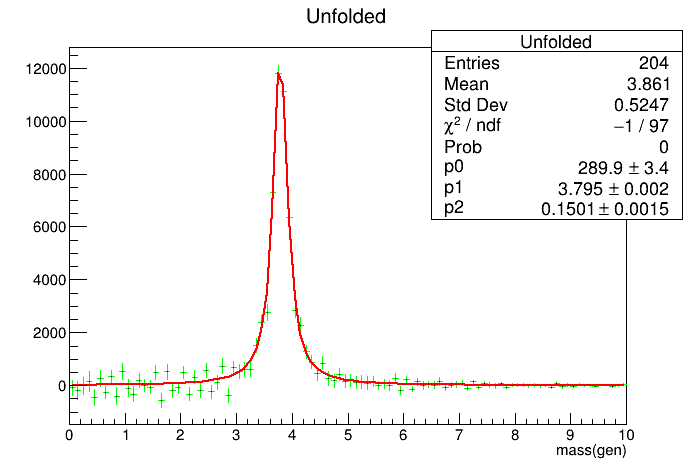

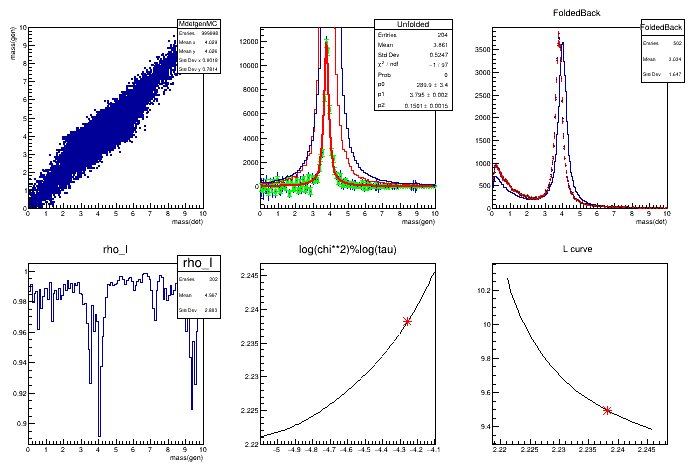

In [8]:
gROOT->GetListOfCanvases()->Draw()